# Unsupervised Learning: Clustering Algorithms - Project

***
## Table of Contents

[1. Import libraries](#1.-Import-libraries) <br>
[2. Loading the Dataset](#2.-Loading-the-Dataset)<br>
[3. Exploratory Data Analysis (EDA)](#3.-Exploratory-Data-Analysis-(EDA))<br>
[4. Correlation Analysis](#4.-Correlation-Analysis)<br>
[5. Feature Scalling](#5.-Feature-Scalling)<br>
[6. K-Means Clustering:](#6.-K-Means-Clustering)
- [6.1. K-Means with Two Clusters](#6.1.-K-Means-with-Two-Clusters)
- [6.2. K-Means with Clusters $\in$ \[1, 20\]](#6.2.-K-Means-with-Clusters-$\in$-[1,-20])
  
[7. Agglomerative Clustering](#7.-Agglomerative-Clustering)

[8. Clustering for Feature Engineering:](#8.-Clustering-for-Feature-Engineering)
- [8.1. Random Forest and K-Means](#8.1.-Random-Forest-and-K-Means)
- [8.2. Logistic Regression and K-Means](#8.2.-Logistic-Regression-and-K-Means)


***
## 1. Import libraries

In [113]:
# Import librarires
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

# Supress warnings
def warn(*args, **kwargs):
    pass
import warnings

warnings.warn = warn

## 2. Loading the Dataset 

In [60]:
# Loading the Dataset
with open('data/Wine_Quality_Data.pickle', 'rb') as to_read:
    data = pd.read_pickle(to_read)
    
data.head(8).round(3).T

0      1      2      3      4      5      6      7
fixed_acidity           7.4    7.8    7.8   11.2    7.4    7.4    7.9    7.3
volatile_acidity        0.7   0.88   0.76   0.28    0.7   0.66    0.6   0.65
citric_acid             0.0    0.0   0.04   0.56    0.0    0.0   0.06    0.0
residual_sugar          1.9    2.6    2.3    1.9    1.9    1.8    1.6    1.2
chlorides             0.076  0.098  0.092  0.075  0.076  0.075  0.069  0.065
free_sulfur_dioxide    11.0   25.0   15.0   17.0   11.0   13.0   15.0   15.0
total_sulfur_dioxide   34.0   67.0   54.0   60.0   34.0   40.0   59.0   21.0
density               0.998  0.997  0.997  0.998  0.998  0.998  0.996  0.995
pH                     3.51    3.2   3.26   3.16   3.51   3.51    3.3   3.39
sulphates              0.56   0.68   0.65   0.58   0.56   0.56   0.46   0.47
alcohol                 9.4    9.8    9.8    9.8    9.4    9.4    9.4   10.0
quality                   5      5      5      6      5      5      5      7
color                   red    red    red    red    red    red    red    red

## 3. Exploratory Data Analysis (EDA)

In [61]:
# Check the number of rows and columns in the original dataset
print(f'There are {data.shape[0]} rows and {data.shape[1]} columns in the original dataset')

There are 6497 rows and 13 columns in the original dataset


In [62]:
# Data types
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [5]:
# Value counts
data.color.value_counts()

color
white    4898
red      1599
Name: count, dtype: int64

In [6]:
# The distribution of quality values
data.quality.value_counts().sort_index()

quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

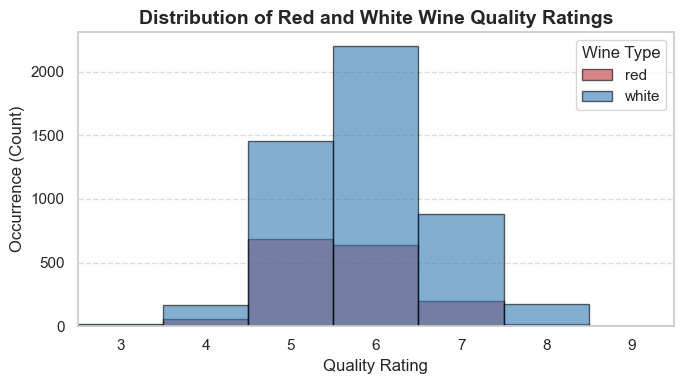

In [63]:
# Histogram: The distribution of quality values

bin_edges = np.arange(3, 11)  
bin_centers = bin_edges[:-1] + 0.5
quality_range = (min(bin_edges), max(bin_edges))

# Set a professional plotting style globally
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

# Plotting Function
def plot_quality_distribution(df: pd.DataFrame, ax: plt.Axes, colors: dict):
    
    for color, plot_color in colors.items():
        quality_data = df.loc[df['color'] == color, 'quality']
        
        # Plotting
        quality_data.plot(kind='hist', bins=bin_edges, 
            alpha=0.6, ax=ax, 
            color=plot_color, label=color,
            edgecolor='black')
    
    # Customization
    ax.legend(loc='best', title='Wine Type')
    ax.set_xlabel('Quality Rating', fontsize=12)
    ax.set_ylabel('Occurrence (Count)', fontsize=12)
    ax.set_title('Distribution of Red and White Wine Quality Ratings', fontsize=14, fontweight='bold')

    # X-axis configurations
    ax.set_xticks(bin_centers)
    ax.set_xticklabels(bin_edges[:-1])
    ax.set_xlim(quality_range)
    
    # Grid appearance
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', visible=False)


# Define custom colors
custom_colors = {
    'red': sns.color_palette("RdBu")[0],  
    'white': sns.color_palette("RdBu")[-1]
}

# Create figure and axes
fig, ax = plt.subplots(figsize=(7,4))

# Call the encapsulated plotting function
plot_quality_distribution(data, ax, custom_colors)

plt.tight_layout()
plt.show();

## 4. Correlation Analysis

In [64]:
# The correlation matrix
numeric_columns = [x for x in data.columns if x not in ['quality', 'color']]
corr_matrix = data[numeric_columns].corr()

# Strip out the diagonal values (for the purpose of the next transformations)
for x in range(len(numeric_columns)):
    corr_matrix.iloc[x,x] = 0.0

# Correlation matrix (with stripped diagonal)
corr_matrix.style.format(precision=2).background_gradient(cmap='Blues_r')

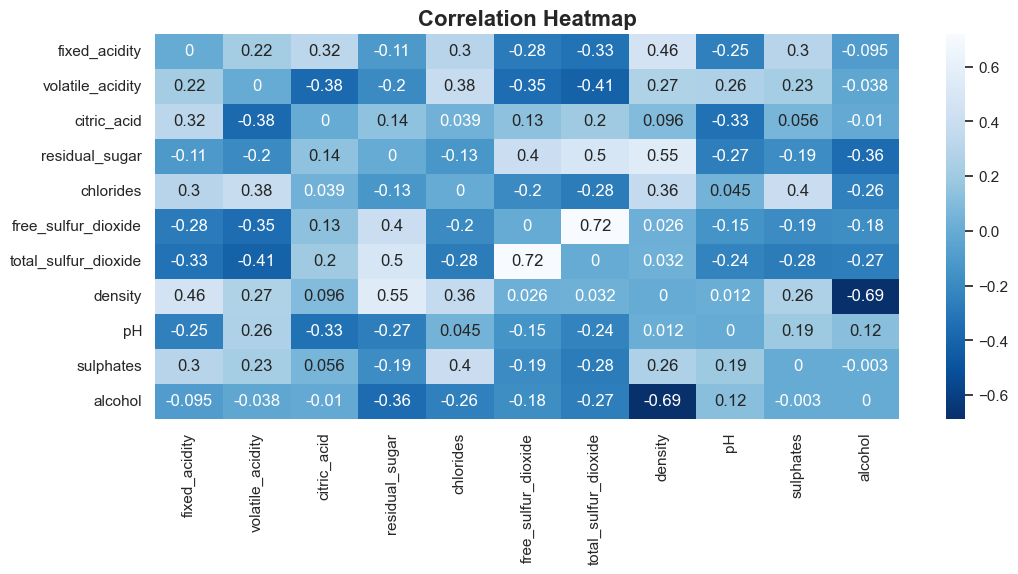

In [65]:
# Correlation heatmap (with stripped diagonal)
def corr_heatmap(matrix):
    plt.figure(figsize=(12, 5))
    sns.heatmap(matrix, annot=True, cmap='Blues_r')
    plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.show()

corr_heatmap(corr_matrix)

In [66]:
# Pairwise absolute maximal correlations
abs_corr = corr_matrix.abs().idxmax()

print(abs_corr)

fixed_acidity                        density
volatile_acidity        total_sulfur_dioxide
citric_acid                 volatile_acidity
residual_sugar                       density
chlorides                          sulphates
free_sulfur_dioxide     total_sulfur_dioxide
total_sulfur_dioxide     free_sulfur_dioxide
density                              alcohol
pH                               citric_acid
sulphates                          chlorides
alcohol                              density
dtype: object


In [67]:
# An examination of the skew values
skew_columns = (data[numeric_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.70]

print(skew_columns)

chlorides              5.399828
sulphates              1.797270
fixed_acidity          1.723290
volatile_acidity       1.495097
residual_sugar         1.435404
free_sulfur_dioxide    1.220066
dtype: float64


In [73]:
# Log transformation on skewed columns
for col in skew_columns.index.tolist():
    data[col] = np.log1p(data[col])

print(data.round(2).head(6).T)

                         0     1     2     3     4     5
fixed_acidity         0.37  0.37  0.37  0.38  0.37  0.37
volatile_acidity      0.24  0.25  0.24  0.15  0.24  0.23
citric_acid            0.0   0.0  0.04  0.56   0.0   0.0
residual_sugar        0.31  0.33  0.32  0.31  0.31  0.31
chlorides             0.06  0.08  0.07  0.06  0.06  0.06
free_sulfur_dioxide   0.38   0.4  0.39  0.39  0.38  0.39
total_sulfur_dioxide  34.0  67.0  54.0  60.0  34.0  40.0
density                1.0   1.0   1.0   1.0   1.0   1.0
pH                    3.51   3.2  3.26  3.16  3.51  3.51
sulphates             0.22  0.23  0.23  0.22  0.22  0.22
alcohol                9.4   9.8   9.8   9.8   9.4   9.4
quality                  5     5     5     6     5     5
color                  red   red   red   red   red   red


## 5. Feature Scalling

In [74]:
# Standard Scaler
sc = StandardScaler()
data[numeric_columns] = sc.fit_transform(data[numeric_columns])

data.sample(8).round(3).T

5284   845    5991   104    1084   6340   5844   697 
fixed_acidity        -0.248  -0.64 -0.849  0.112  0.112 -0.958  0.444 -0.064
volatile_acidity     -1.575  1.705 -0.496  1.084  0.481  -0.32  0.286  1.741
citric_acid           0.629 -0.748  0.835 -0.541 -0.128 -0.059  1.042 -2.055
residual_sugar        1.277 -0.819  1.406 -0.511 -0.819  0.231  1.297  -0.58
chlorides            -0.377  0.957   0.12  0.585  0.689 -0.783 -0.659  0.445
free_sulfur_dioxide   1.256 -0.641  0.617  -2.58  0.375  0.691  0.691 -1.585
total_sulfur_dioxide   1.19 -1.499  0.907 -1.411 -0.809  0.376  0.005 -1.606
density               0.908  0.732  1.115  0.435  0.718 -0.839  1.175  0.835
pH                    0.134  2.311 -0.488  0.694  1.253  0.134  -1.11  1.564
sulphates             1.622  0.993 -0.013 -0.254   0.56 -0.423 -0.091  1.051
alcohol              -0.245  -0.58 -1.083 -0.915 -0.832  0.342 -1.083 -0.832
quality                   6      5      5      5      6      6      5      6
color                 white    red  white    red    red  white  white    red

<Figure size 2000x1600 with 0 Axes>

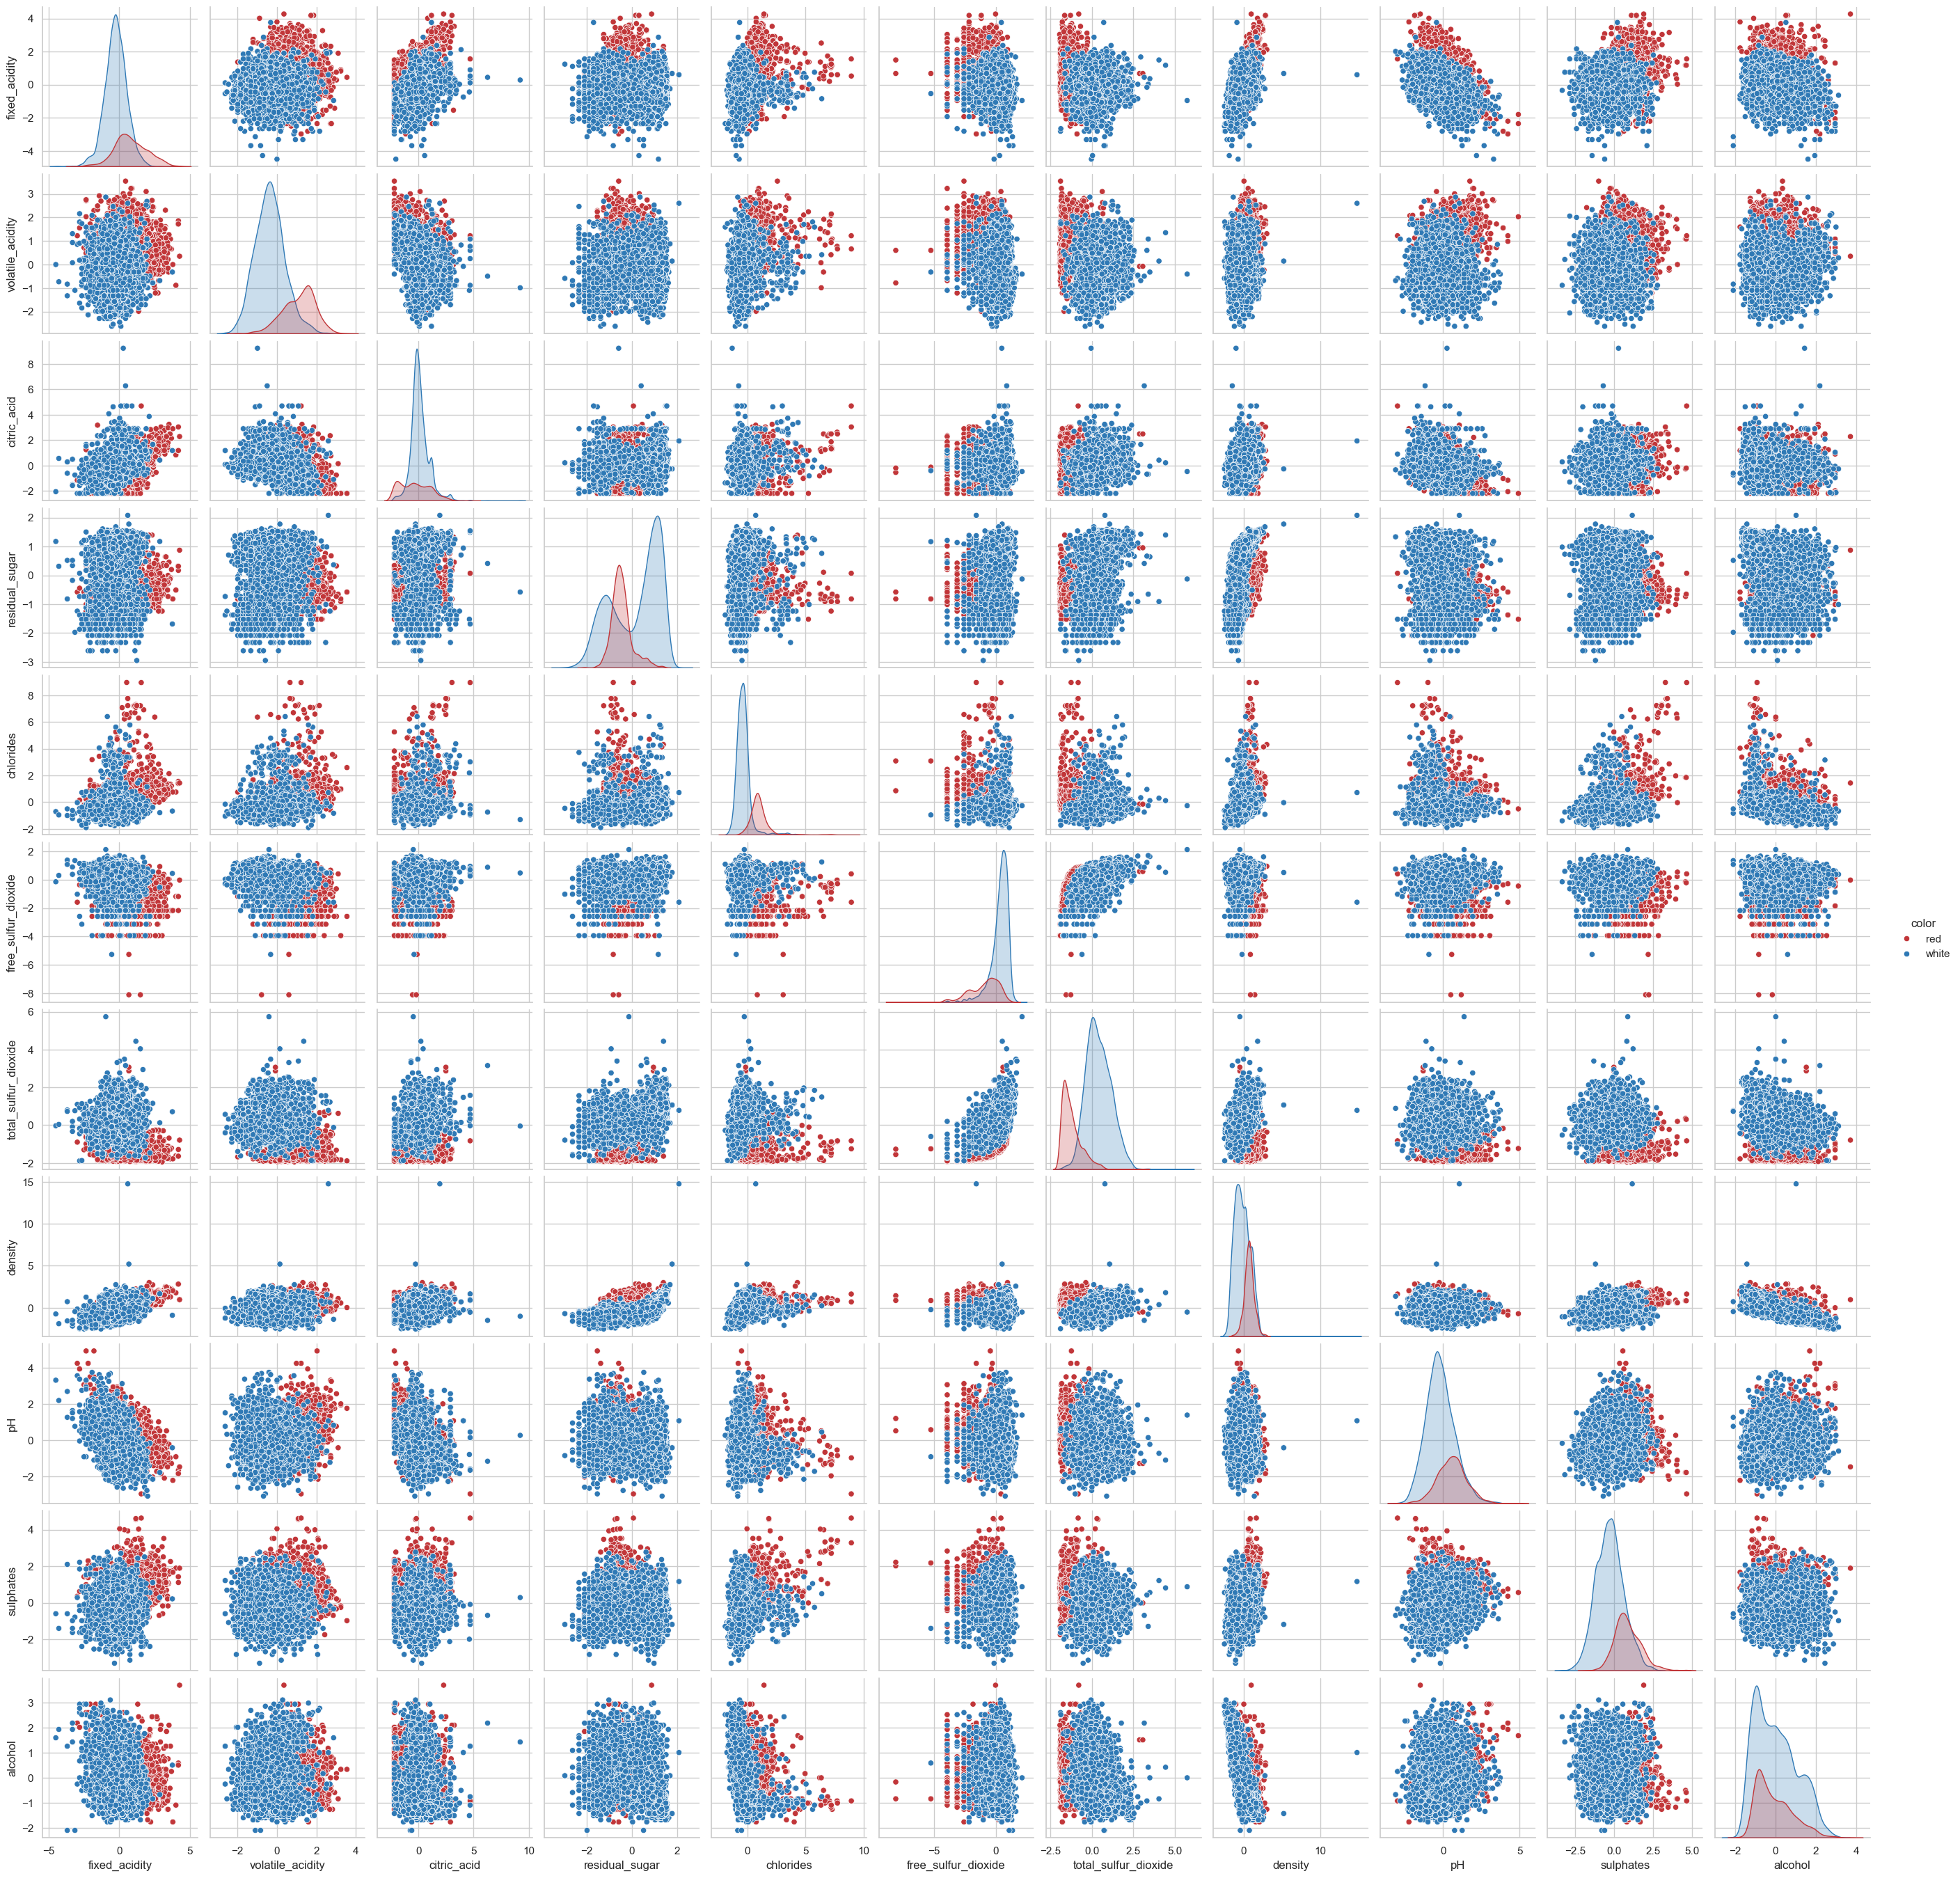

In [80]:
# Pairplot of the transformed and scaled features
sns.set_context('notebook')

plt.figure(figsize=(20, 16)) 

sns.pairplot(data[numeric_columns + ['color']], 
             hue='color', hue_order=['red', 'white'], 
             palette={'red': custom_colors['red'], 'white': custom_colors['white']},
            )
plt.show();

## 6. K-Means Clustering

### 6.1. K-Means with Two Clusters

In [81]:
# K-Means and the use of distance metrics
km = KMeans(n_clusters=2, random_state=36)
km = km.fit(data[numeric_columns])

data['kmeans'] = km.predict(data[numeric_columns])

In [92]:
outcome = data.groupby(['kmeans', 'color']).agg(number=('color', 'size'))
outcome.style.background_gradient(cmap='RdBu')

### 6.2. K-Means with Clusters $\in$ [1, 20]

In [93]:
# Create and fit a range of models
km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[numeric_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

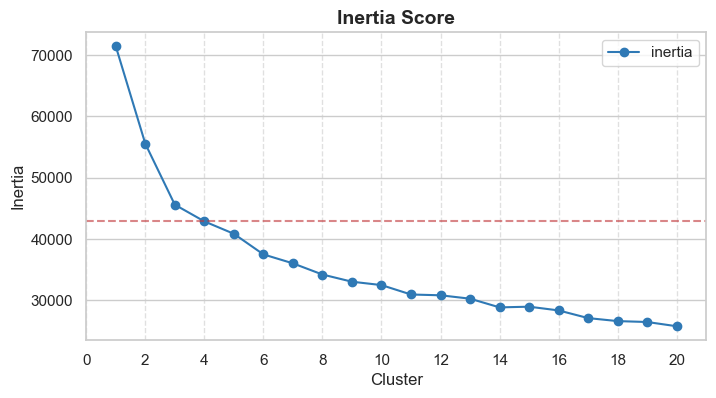

In [95]:
# Inertia Plot
inert_data = pd.concat(km_list, axis=1).T
inert_data=inert_data[['clusters','inertia']].set_index('clusters')

clust_range = pd.Series(range(1, 21), name='clusters')
inert_data = inert_data.reindex(clust_range)
inert_data.index = pd.to_numeric(inert_data.index)

ax = inert_data.plot(marker='o',ls='-', figsize=(8, 4), color =custom_colors['white'])
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia')

ax.axhline(inert_data.loc[4, 'inertia'], ls='--', alpha=0.6, color=custom_colors['red'])

ax.grid(True, axis='x', ls='--', alpha=0.6)

plt.title('Inertia Score', fontsize=14, fontweight='bold')
plt.show();

## 7. Agglomerative Clustering

In [106]:
# Agglomerative Clustering with Two Clusters
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data[numeric_columns])

# to extend data table with prediction results
data['agglom'] = ag.fit_predict(data[numeric_columns])
data.round(2).sample(8).T

2399   6352   3761  111    6067   2946   4948   2228
fixed_acidity           0.6  -1.67   1.96  1.04  -0.85    0.9  -0.64   -1.3
volatile_acidity      -0.32  -1.45   1.08  1.63  -0.88   0.29  -1.33    0.0
citric_acid             1.8   -0.4  -0.61 -1.57  -0.54   0.56  -0.33   0.08
residual_sugar         1.18  -1.12  -0.39 -0.51  -1.52   0.72   1.09  -1.52
chlorides              -0.7  -0.87   1.15  1.06  -0.11  -0.58  -0.26   -0.7
free_sulfur_dioxide    0.74   0.51  -0.21 -1.02   0.38   0.51   0.18   0.03
total_sulfur_dioxide    0.8  -0.28  -0.01 -0.14  -0.37   0.82  -0.26   -0.3
density                 1.0  -1.31   0.03  0.57  -1.45  -0.37   0.42  -1.03
pH                    -0.99   1.32  -2.79 -0.43   0.13  -0.43   0.76  -0.24
sulphates             -0.88   1.57   -0.6  0.99   0.43  -1.63  -0.09   0.63
alcohol               -1.33   1.26  -0.92 -0.58   0.68   1.18   -0.5   0.01
quality                   6      6      6     5      6      7      6      6
color                 white  white  white   red  white  white  white  white
kmeans                    0      0      1     1      0      0      0      0
agglom                    0      0      1     1      0      0      0      0

In [107]:
# Depict data for Agglomerative Clustering:
outcome= data.groupby(['color', 'agglom']).agg(number=('kmeans', 'size'))
outcome.style.background_gradient(cmap='RdBu_r')

In [108]:
# Depict comparison data for K-Means Clustering:
outcome=data.groupby(['color', 'kmeans']).agg(number=('agglom', 'size'))
outcome.style.background_gradient(cmap='RdBu_r')

In [109]:
# Comparison results: K-Means and Agglomerative Clustering
outcome=data.groupby(['color', 'agglom', 'kmeans']).agg(number=('color', 'size'))
outcome.style.background_gradient(cmap='RdBu_r')

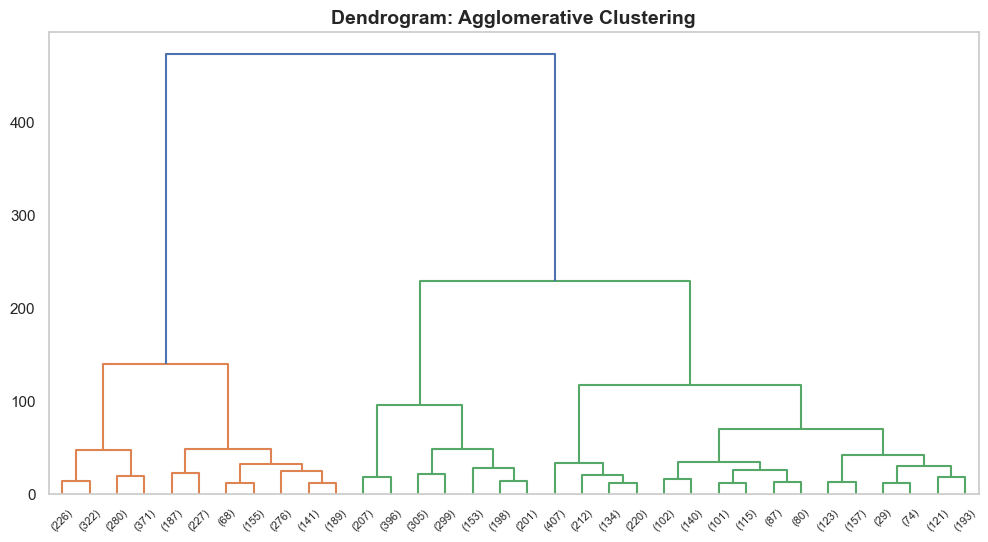

In [132]:
# Dendrogram Plot (agglomerative clustering)
def thousands_formatter(x, pos):
    return f'{x / 1000:.0f}'
     
def dendrogram_plot(model):
    
    Z = hierarchy.linkage(model.children_, method='ward')
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    dendro = hierarchy.dendrogram(Z, orientation='top', 
                                  p=34, truncate_mode='lastp',
                                  show_leaf_counts=True, ax=ax)
    
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(thousands_formatter))
    
    ax.grid(False)
    
    plt.title('Dendrogram: Agglomerative Clustering', fontsize=14, fontweight='bold')
    plt.show();

# Plotting the dendrogram
dendrogram_plot(ag)

## 8. Clustering for Feature Engineering

### 8.1. Random Forest and K-Means

In [138]:
# Create the binary target with quality greater than 7
y = (data['quality'] > 7).astype(int)

# predictor variables without K-Means
X_with_kmeans = data.drop(['agglom', 'color', 'quality'], axis=1)

# predictor variables with K-Means
X_without_kmeans = X_with_kmeans.drop('kmeans', axis=1)

# ten different random forrest classifiers
sss = StratifiedShuffleSplit(n_splits=10, random_state=8965)

def avg_roc_10splits(estimator, X, y):
    
    roc_auc_list = []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        estimator.fit(X_train, y_train)
        
        y_predicted = estimator.predict(X_test)
        
        y_scored = estimator.predict_proba(X_test)[:, 1]
        
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
        
    return np.mean(roc_auc_list)

estimator = RandomForestClassifier()

print("Starting ROC-AUC calculations...")

roc_with_kmeans = avg_roc_10splits(estimator, X_with_kmeans, y)
roc_without_kmeans = avg_roc_10splits(estimator, X_without_kmeans, y)

print(f'\nResults:')
print(f'Random Forest (without K-means cluster): ROC-AUC is {roc_without_kmeans:.4f}')
print(f'Random Forest (with K-means cluster): ROC-AUC is {roc_with_kmeans:.4f}')

# Conditional interpretation of the results
if roc_with_kmeans > roc_without_kmeans:
    print('\nConclusion: Including the K-Means cluster feature slightly improved model performance.')
elif roc_with_kmeans < roc_without_kmeans:
    print('\nConclusion: Including the K-Means cluster feature slightly decreased model performance.')
else:
    print('\nConclusion: Including the K-Means cluster feature had no impact on model performance.')

Starting ROC-AUC calculations...

Results:
Random Forest (without K-means cluster): ROC-AUC is 0.8932
Random Forest (with K-means cluster): ROC-AUC is 0.9081

Conclusion: Including the K-Means cluster feature slightly improved model performance.


### 8.2. Logistic Regression and K-Means

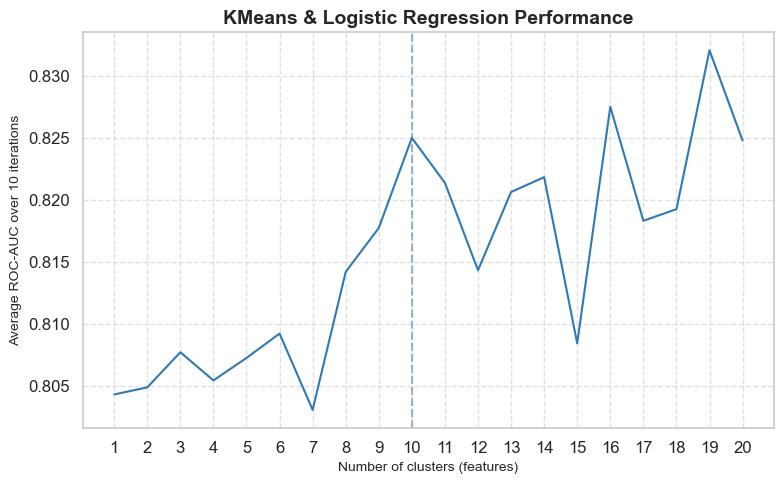

In [141]:
# Chaning the number of labeles and Logistic Regression Performance

X_data = data[numeric_columns].copy()

sss = StratifiedShuffleSplit(n_splits=10, random_state=8965)

def create_kmeans_columns(n):
    km = KMeans(n_clusters=n)
    km.fit(X_data)
    km_col = pd.Series(km.predict(X_data))
    km_cols = pd.get_dummies(km_col, prefix='kmeans_cluster')
    outcome = pd.concat([X_data, km_cols], axis=1)
    return outcome

estimator = LogisticRegression()

ns = range(1, 21) # number of clusters

roc_auc_list = [avg_roc_10splits(estimator, create_kmeans_columns(n), y) for n in ns]


def plot_performance(ns, roc_auc_list, color):
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ns, roc_auc_list, color=color)

    ax.set_xticks(ns)
    ax.set_xlabel('Number of clusters (features)', fontsize=10)
    ax.set_ylabel('Average ROC-AUC over 10 iterations', fontsize=10)
    ax.set_title('KMeans & Logistic Regression Performance', fontsize=14, fontweight='bold')
    
    ax.axvline(10, ls='--', alpha=0.5, color =custom_colors['white'])
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show();

#Plot the chart
plot_performance(ns, roc_auc_list, custom_colors['white'])

***
Author: Dr.Olga Khon, PhD in Finance